In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
if "google.colab" in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

In [3]:
!pip install -q mlflow
!pip install -q python-dotenv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.4/27.4 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 81.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 623.0/623.0 kB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.5 MB/s eta 0:00:00


In [4]:
import os
project_folder = '/content/drive/MyDrive/nba-project'
os.chdir(project_folder)
pickles_folder = os.path.join(os.getcwd(), 'datasets')
os.getcwd()

'/content/drive/MyDrive/nba-project'

In [5]:
import custom_modules.modelling_lib_rodrixx as mod
import custom_modules.preprocessing_lib_rodrixx as prep

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import os

from lightgbm import LGBMRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

from dotenv import load_dotenv

from mlflow.server import get_app_client
import mlflow

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [6]:
env_path = os.path.join(os.getcwd(), 'env_files', '.env')
load_dotenv(env_path)
dataframes_path = os.path.join(os.getcwd(), 'datasets')
csv_path = os.path.join(os.getcwd(), 'column_csv')

In [7]:
df = pd.read_pickle(os.path.join(dataframes_path, 'stats_1982_to_2024.pkl'))

In [8]:
df.head()

,Player,Pos,Age,Tm,G,GS,MP_pg,FG_pg,FGA_pg,FG%,...,DBPM_rank,BPM_rank,VORP_rank,%W,GT,%W_rank,%G,Votes,Share,MaxVotes
0,Kareem Abdul-Jabbar,C,34,LAL,76,76,35.2,9.9,17.1,0.579,...,20,5,8,0.695,82,3,0.927,31,0.045,690
1,Alvan Adams,C,27,PHO,79,75,30.3,6.4,13.0,0.494,...,10,13,15,0.561,82,10,0.963,0,0.000,690
2,Mark Aguirre,SF,22,DAL,51,20,28.8,7.5,16.1,0.465,...,48,34,36,0.341,82,36,0.622,0,0.000,690
3,Danny Ainge,SG,22,BOS,53,1,10.6,1.5,4.2,0.357,...,22,68,47,0.768,82,1,0.646,0,0.000,690
4,Tiny Archibald,PG,33,BOS,68,51,31.9,4.5,9.6,0.472,...,45,40,35,0.768,82,1,0.829,0,0.000,690


In [9]:
cols_tot_rank = [col for col in df.columns if '_tot' in col or '_rank' in col]
cols_to_drop = ['G', 'GS', 'GT', 'Votes', 'MaxVotes', 'Tm', 'FG_tot', '3PA_tot', '2PA_tot', 'FGA_rank_tot', 'Tm', 'Pos', 'Age', 'G', 'GS', 'FGA_pg', 'FG%', '3P_pg', '3PA_pg', '3P%', '2PA_pg', '2P%', 'eFG%', 'FT%', 'ORB_pg', 'DRB_pg', 'PF_pg', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'OBPM', 'DBPM']
cols_to_drop += cols_tot_rank
cols_to_filter = ['PER', 'WS/48', 'BPM', 'USG%']

In [10]:
pipe_clean = Pipeline(steps = [
    ('DropPlayersMultiTeams', prep.DropPlayersMultiTeams()),
    ('AdjustColumns', prep.AdjustCols(cols_to_adjust = cols_to_filter)),
    ('SetIndex', prep.SetIndex()),
    ('DropColumns', prep.DropColumns(cols_to_drop)),
    ('DropPlayers', prep.DropPlayers()),
])

In [11]:
df = pipe_clean.fit_transform(df)

In [12]:
df.head()

,,MP_pg,FG_pg,2P_pg,FT_pg,FTA_pg,TRB_pg,AST_pg,STL_pg,BLK_pg,TOV_pg,...,USG%,OWS,DWS,WS,WS/48,BPM,VORP,%W,%G,Share
Player,Season,,,,,,,,,,,,,,,,,,,,,
Kareem Abdul-Jabbar,1982,35.2,9.9,9.9,4.1,5.8,8.7,3.0,0.8,2.7,3.0,...,0.256,6.9,3.9,10.7,0.192,5.0,4.7,0.695,0.927,0.045
Alvan Adams,1982,30.3,6.4,6.4,2.3,2.9,7.4,4.5,1.4,1.0,2.5,...,0.228,2.5,4.7,7.2,0.144,3.6,3.4,0.561,0.963,0.000
Mark Aguirre,1982,28.8,7.5,7.0,3.3,4.8,4.9,3.2,0.7,0.4,2.6,...,0.298,1.0,0.8,1.9,0.061,0.7,1.0,0.341,0.622,0.000
Danny Ainge,1982,10.6,1.5,1.4,1.1,1.2,1.1,1.6,0.7,0.1,1.0,...,0.215,-0.3,0.8,0.5,0.042,-2.7,-0.1,0.768,0.646,0.000
Tiny Archibald,1982,31.9,4.5,4.4,3.5,4.6,1.7,8.0,0.8,0.0,2.6,...,0.179,3.4,1.8,5.2,0.115,0.1,1.1,0.768,0.829,0.000


In [13]:
len(df[df.index.get_level_values(1) > 2017]) / len(df)

0.20560102029971303

In [14]:
val_df = df[df.index.get_level_values(1) > 2017]
dev_df = df[df.index.get_level_values(1) <= 2017]

In [15]:
dev_df, sampling_ratio = mod.oversample(dev_df, os_param = 'ros', sampling_strategy = .4)

In [16]:
X_train = dev_df.drop('Share', axis=1)
y_train = dev_df[['Share']]

X_val = val_df.drop('Share', axis=1)
y_val = val_df[['Share']]

In [17]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20098 entries, 0 to 20097
Data columns (total 22 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MP_pg   20098 non-null  float64
 1   FG_pg   20098 non-null  float64
 2   2P_pg   20098 non-null  float64
 3   FT_pg   20098 non-null  float64
 4   FTA_pg  20098 non-null  float64
 5   TRB_pg  20098 non-null  float64
 6   AST_pg  20098 non-null  float64
 7   STL_pg  20098 non-null  float64
 8   BLK_pg  20098 non-null  float64
 9   TOV_pg  20098 non-null  float64
 10  PTS_pg  20098 non-null  float64
 11  %GS     20098 non-null  float64
 12  PER     20098 non-null  float64
 13  USG%    20098 non-null  float64
 14  OWS     20098 non-null  float64
 15  DWS     20098 non-null  float64
 16  WS      20098 non-null  float64
 17  WS/48   20098 non-null  float64
 18  BPM     20098 non-null  float64
 19  VORP    20098 non-null  float64
 20  %W      20098 non-null  float64
 21  %G      20098 non-null  float64
dty

In [18]:
scaler = MinMaxScaler()
scaler.fit(pd.concat([X_train, X_val], ignore_index = True))

MinMaxScaler()

In [19]:
datasets = {'train': X_train, 'val': X_val}
real_targets = {'train': y_train, 'val': y_val}

In [20]:
# pipe_scale = Pipeline(steps = [
#     ('Scaler', scaler),
#     ('ArrayToDf', prep.ArrayToDataFrame(columns = X_train.columns))
# ])

In [21]:
# for key, dataset in datasets.items():
#     index_param = dataset.index
#     pipe_scale.set_params(**{'ArrayToDf__index': index_param})
#     datasets[key] = pipe_scale.transform(dataset)

In [22]:
mlflow.set_experiment('LightGBM v2')

<Experiment: artifact_location='gs://nba-mvp-prediction-mlflow-artifacts/9', creation_time=1732911721100, experiment_id='9', last_update_time=1732911721100, lifecycle_stage='active', name='LightGBM v2', tags={}>

In [23]:
param_grid = {
    'num_leaves': [50],
    'n_estimators': [130],
    'learning_rate': [.5],
    'max_depth': [3],
    'min_child_samples': [50]
    }

In [25]:
with mlflow.start_run():
    estimator = LGBMRegressor(random_state = 23)

    model = GridSearchCV(estimator, param_grid, scoring = ('neg_root_mean_squared_error', 'r2'), refit = 'neg_root_mean_squared_error', cv = 10, verbose = 2)

    model.fit(X_train, y_train)

    results = model.cv_results_

    cv_scores = mod.get_cv_scores(results)

    best_model, best_params, best_cv_score = mod.retrieve_best(model)

    predicted_targets = mod.predict_model(best_model, datasets)

    mod.log_sampling_ratio_mlflow(sampling_ratio)

    mod.log_params_mlflow_lgbm(best_params)

    mod.log_metrics_mlflow(real_targets, predicted_targets, cv_scores)

    mod.log_advanced_metrics_mlflow(real_targets['val'], predicted_targets['val'])

    mod.log_model_mlflow(best_model)

    mod.log_features_mlflow(X_train, csv_path)

    mod.log_important_features_mlflow(mod.display_feature_importances_lgbm(best_model))

    mod.log_val_results_mlflow(*mod.display_val_results_graphs(real_targets['val'], predicted_targets['val']))

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3516
[LightGBM] [Info] Number of data points in the train set: 18088, number of used features: 22
[LightGBM] [Info] Start training from score 0.050363
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

2024/12/14 11:33:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run legendary-hawk-570 at: https://nba-mvp-prediction.xyz/mlflow/#/experiments/9/runs/6945679c55f74bcbb60f80f51321dd11
🧪 View experiment at: https://nba-mvp-prediction.xyz/mlflow/#/experiments/9


In [26]:
mod.display_metrics(real_targets, predicted_targets, cv_scores)

,Train,CV,Validation
RMSE,0.012344,0.016764,0.028025
R2,0.993860,0.964074,0.739496


In [27]:
contenders_df, no_contenders_df = mod.get_val_results(real_targets['val'], predicted_targets['val'])

In [28]:
mod.display_val_results(contenders_df, no_contenders_df)

Contenders Results:


,,Share,PredShare
Player,Season,,
James Harden,2018,0.955,0.899384
LeBron James,2018,0.731,0.332851
Anthony Davis,2018,0.441,0.157705
Damian Lillard,2018,0.205,0.124782
Russell Westbrook,2018,0.075,0.190731
Giannis Antetokounmpo,2018,0.074,-0.069120
Kevin Durant,2018,0.065,0.259058
DeMar DeRozan,2018,0.032,-0.002492
LaMarcus Aldridge,2018,0.006,0.062802


,,Share,PredShare
Player,Season,,
Giannis Antetokounmpo,2019,0.932,0.869211
James Harden,2019,0.768,0.866381
Paul George,2019,0.352,0.322713
Nikola Jokić,2019,0.210,0.062633
Stephen Curry,2019,0.173,0.155685
Damian Lillard,2019,0.068,0.005460
Joel Embiid,2019,0.049,0.212492
Kevin Durant,2019,0.025,0.225549
Kawhi Leonard,2019,0.013,0.111834


,,Share,PredShare
Player,Season,,
Giannis Antetokounmpo,2020,0.952,0.581784
LeBron James,2020,0.746,0.302758
James Harden,2020,0.363,0.595397
Luka Dončić,2020,0.198,0.227431
Kawhi Leonard,2020,0.166,0.113180
Anthony Davis,2020,0.081,0.040282
Chris Paul,2020,0.026,-0.004945
Damian Lillard,2020,0.023,0.171449
Nikola Jokić,2020,0.018,0.055133


,,Share,PredShare
Player,Season,,
Nikola Jokić,2021,0.961,0.555946
Joel Embiid,2021,0.580,0.296248
Stephen Curry,2021,0.449,0.244779
Giannis Antetokounmpo,2021,0.345,0.060220
Chris Paul,2021,0.138,-0.011728
Luka Dončić,2021,0.042,0.298505
Damian Lillard,2021,0.038,0.166462
Julius Randle,2021,0.020,0.008007
Derrick Rose,2021,0.010,0.000597


,,Share,PredShare
Player,Season,,
Nikola Jokić,2022,0.875,0.480081
Joel Embiid,2022,0.706,0.686380
Giannis Antetokounmpo,2022,0.595,0.482745
Devin Booker,2022,0.216,0.341987
Luka Dončić,2022,0.146,0.165565
Jayson Tatum,2022,0.043,0.186789
Ja Morant,2022,0.010,0.174825
Stephen Curry,2022,0.004,-0.004608
Chris Paul,2022,0.002,-0.009671


,,Share,PredShare
Player,Season,,
Joel Embiid,2023,0.915,0.604103
Nikola Jokić,2023,0.674,0.566474
Giannis Antetokounmpo,2023,0.606,0.378037
Jayson Tatum,2023,0.280,0.347221
Shai Gilgeous-Alexander,2023,0.046,0.004319
Donovan Mitchell,2023,0.030,0.157256
Domantas Sabonis,2023,0.027,0.094036
Luka Dončić,2023,0.010,0.156526
Stephen Curry,2023,0.005,0.106697


,,Share,PredShare
Player,Season,,
Nikola Jokić,2024,0.935,0.835778
Shai Gilgeous-Alexander,2024,0.646,0.576503
Luka Dončić,2024,0.572,0.585929
Giannis Antetokounmpo,2024,0.194,0.471993
Jalen Brunson,2024,0.143,0.160397
Jayson Tatum,2024,0.087,0.308889
Anthony Edwards,2024,0.018,0.246671
Domantas Sabonis,2024,0.003,0.191362
Kevin Durant,2024,0.001,0.035993


No contenders results:


,,Share,PredShare
Player,Season,,
Álex Abrines,2018,0.0,0.000149
Arron Afflalo,2018,0.0,0.000149
Cole Aldrich,2018,0.0,0.000149
Kadeem Allen,2018,0.0,0.000149
Tony Allen,2018,0.0,0.000149
...,...,...,...
Kaiser Gates,2024,0.0,0.000149
Danny Green,2024,0.0,0.000149
Ron Harper Jr.,2024,0.0,0.000149


In [29]:
no_contenders_df[no_contenders_df['PredShare'] > 0.1]

,,Share,PredShare
Player,Season,,
Bradley Beal,2020,0.0,0.156913
Montrezl Harrell,2020,0.0,0.100172
Kyrie Irving,2020,0.0,0.113205
Devin Booker,2021,0.0,0.145639
Kevin Durant,2021,0.0,0.118464
Zach LaVine,2021,0.0,0.102801
Isaiah Hartenstein,2022,0.0,0.108056
Trae Young,2022,0.0,0.257409
Devin Booker,2023,0.0,0.183593


<Axes: title={'center': 'Most important features'}, xlabel='Feature', ylabel='Importance coefficient'>

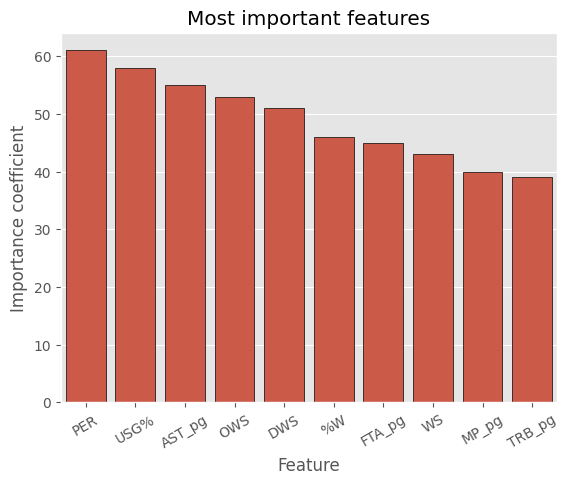

In [31]:
mod.display_feature_importances_lgbm(best_model)

In [32]:
cont_df, no_cont_df = mod.get_val_results(real_targets['val'], predicted_targets['val'])

(<Figure size 4000x4000 with 8 Axes>, <Figure size 4000x4000 with 8 Axes>)

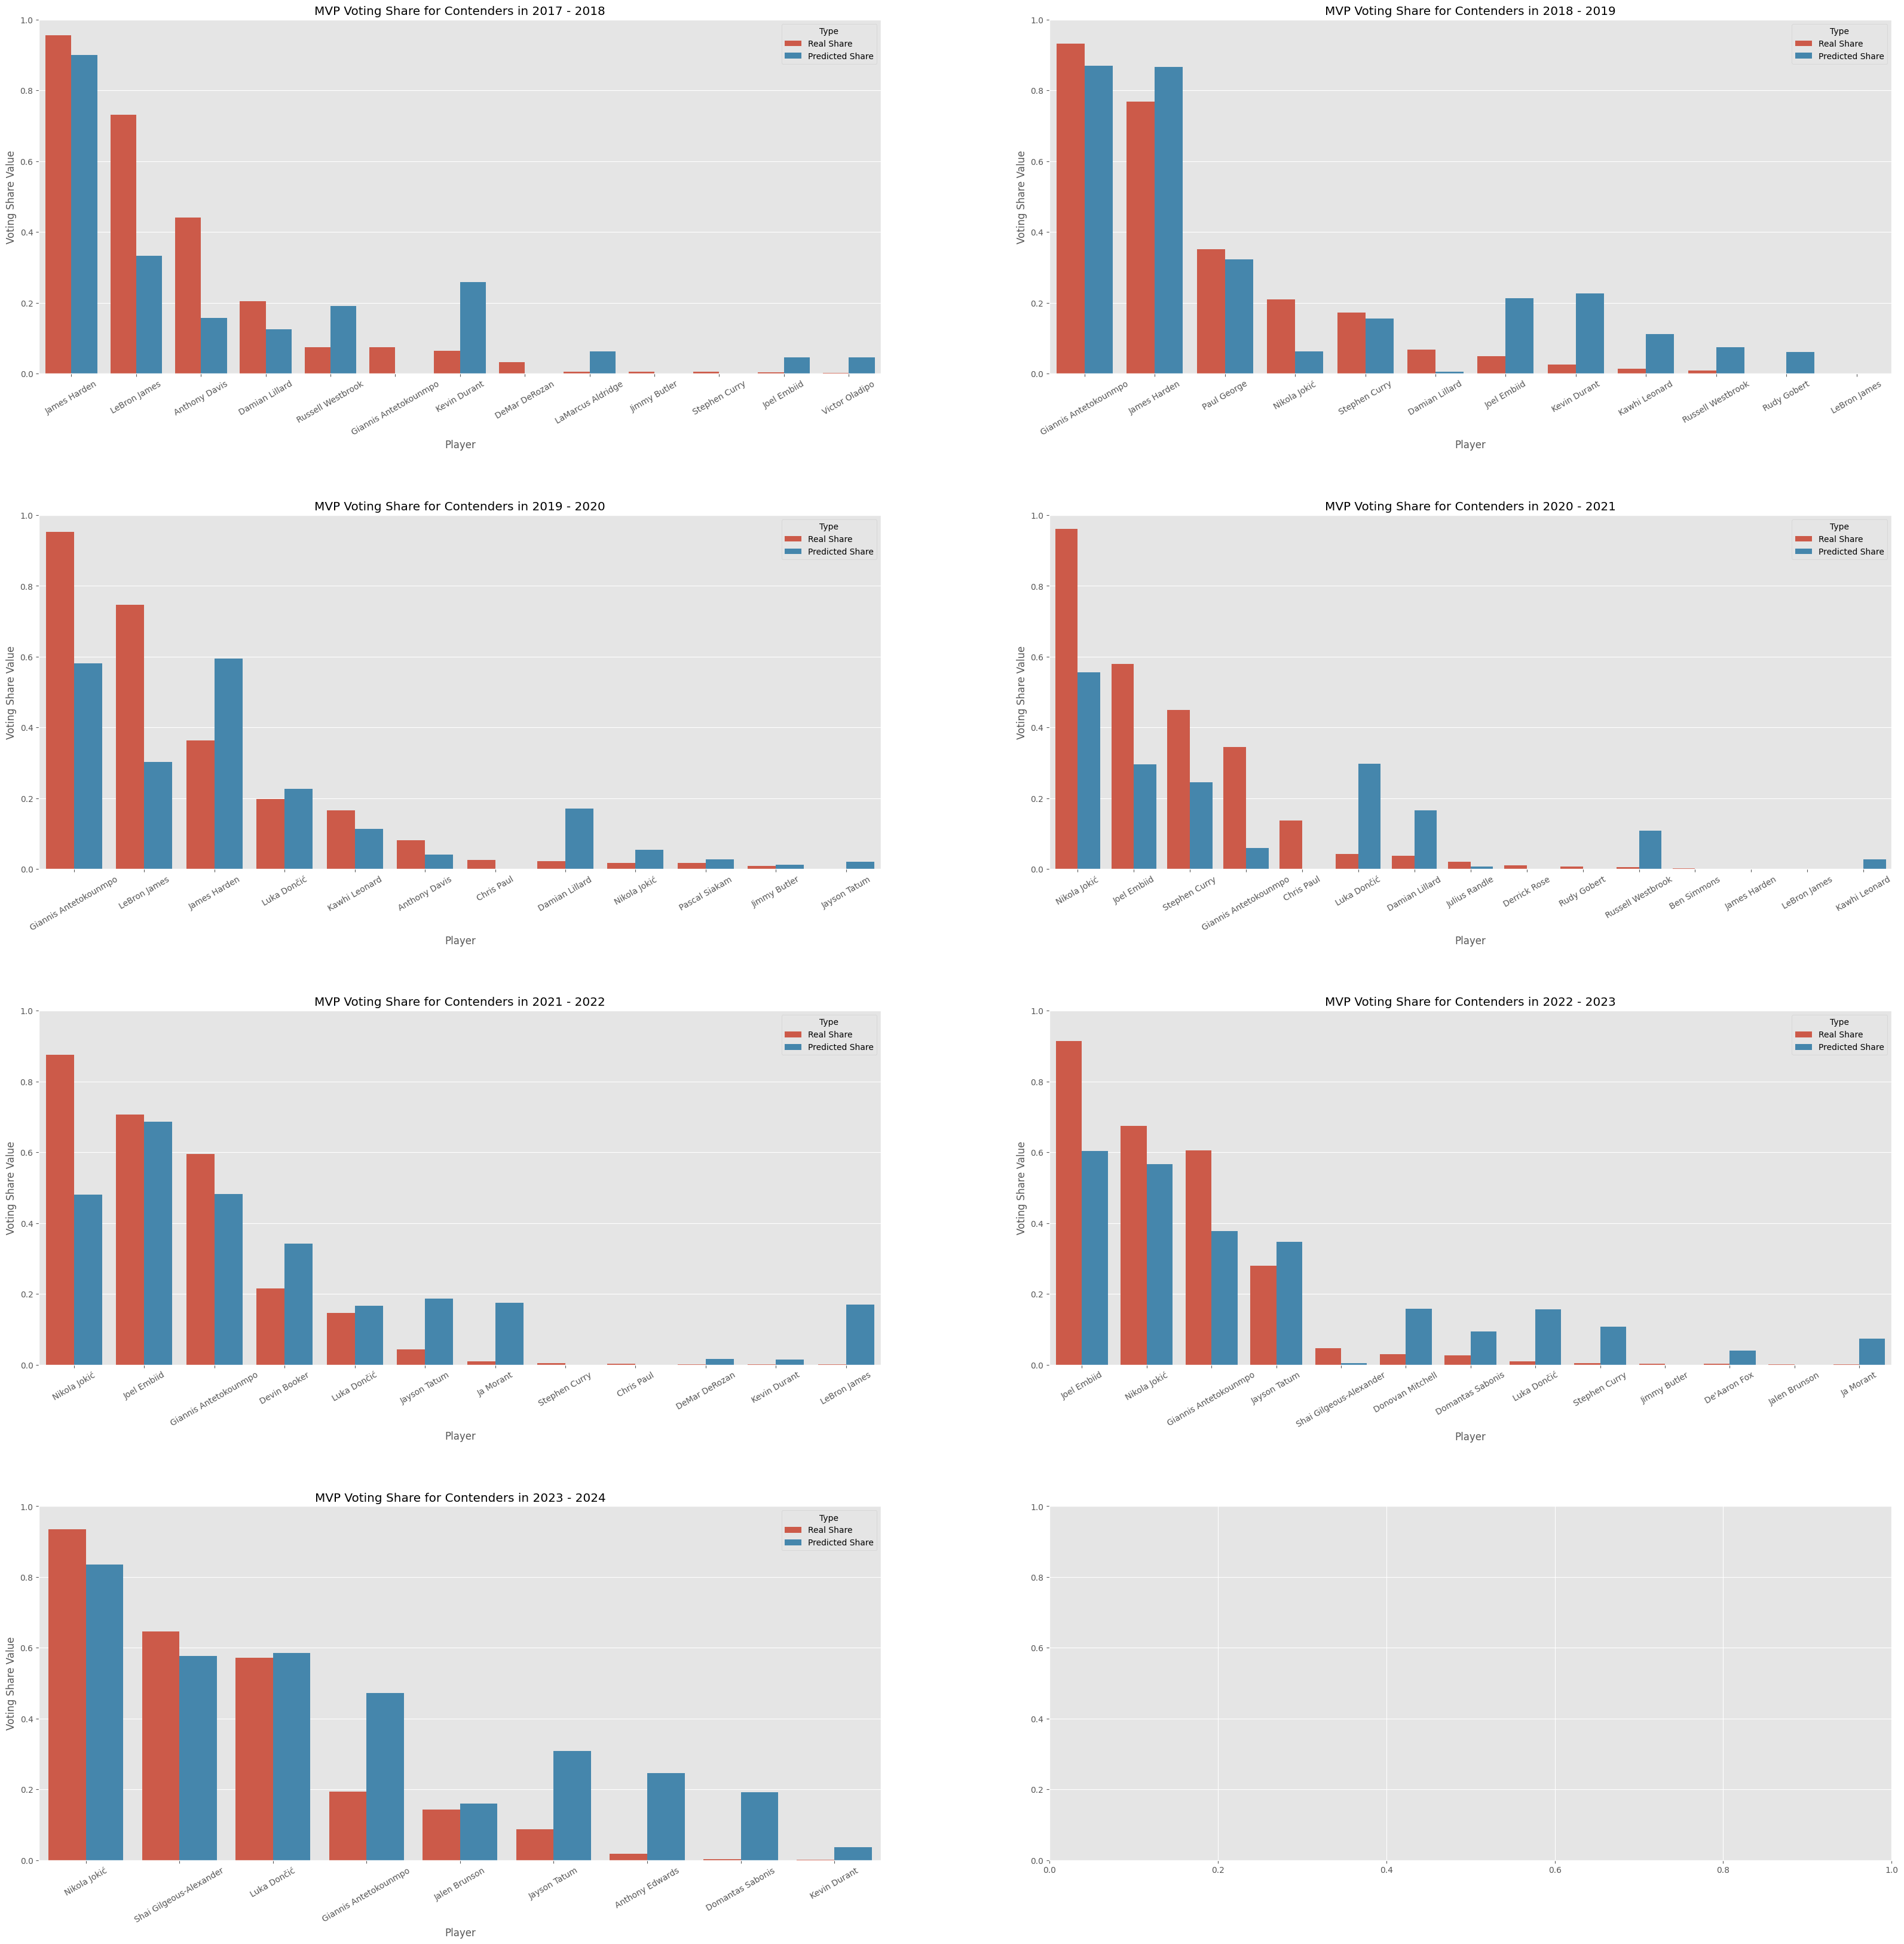

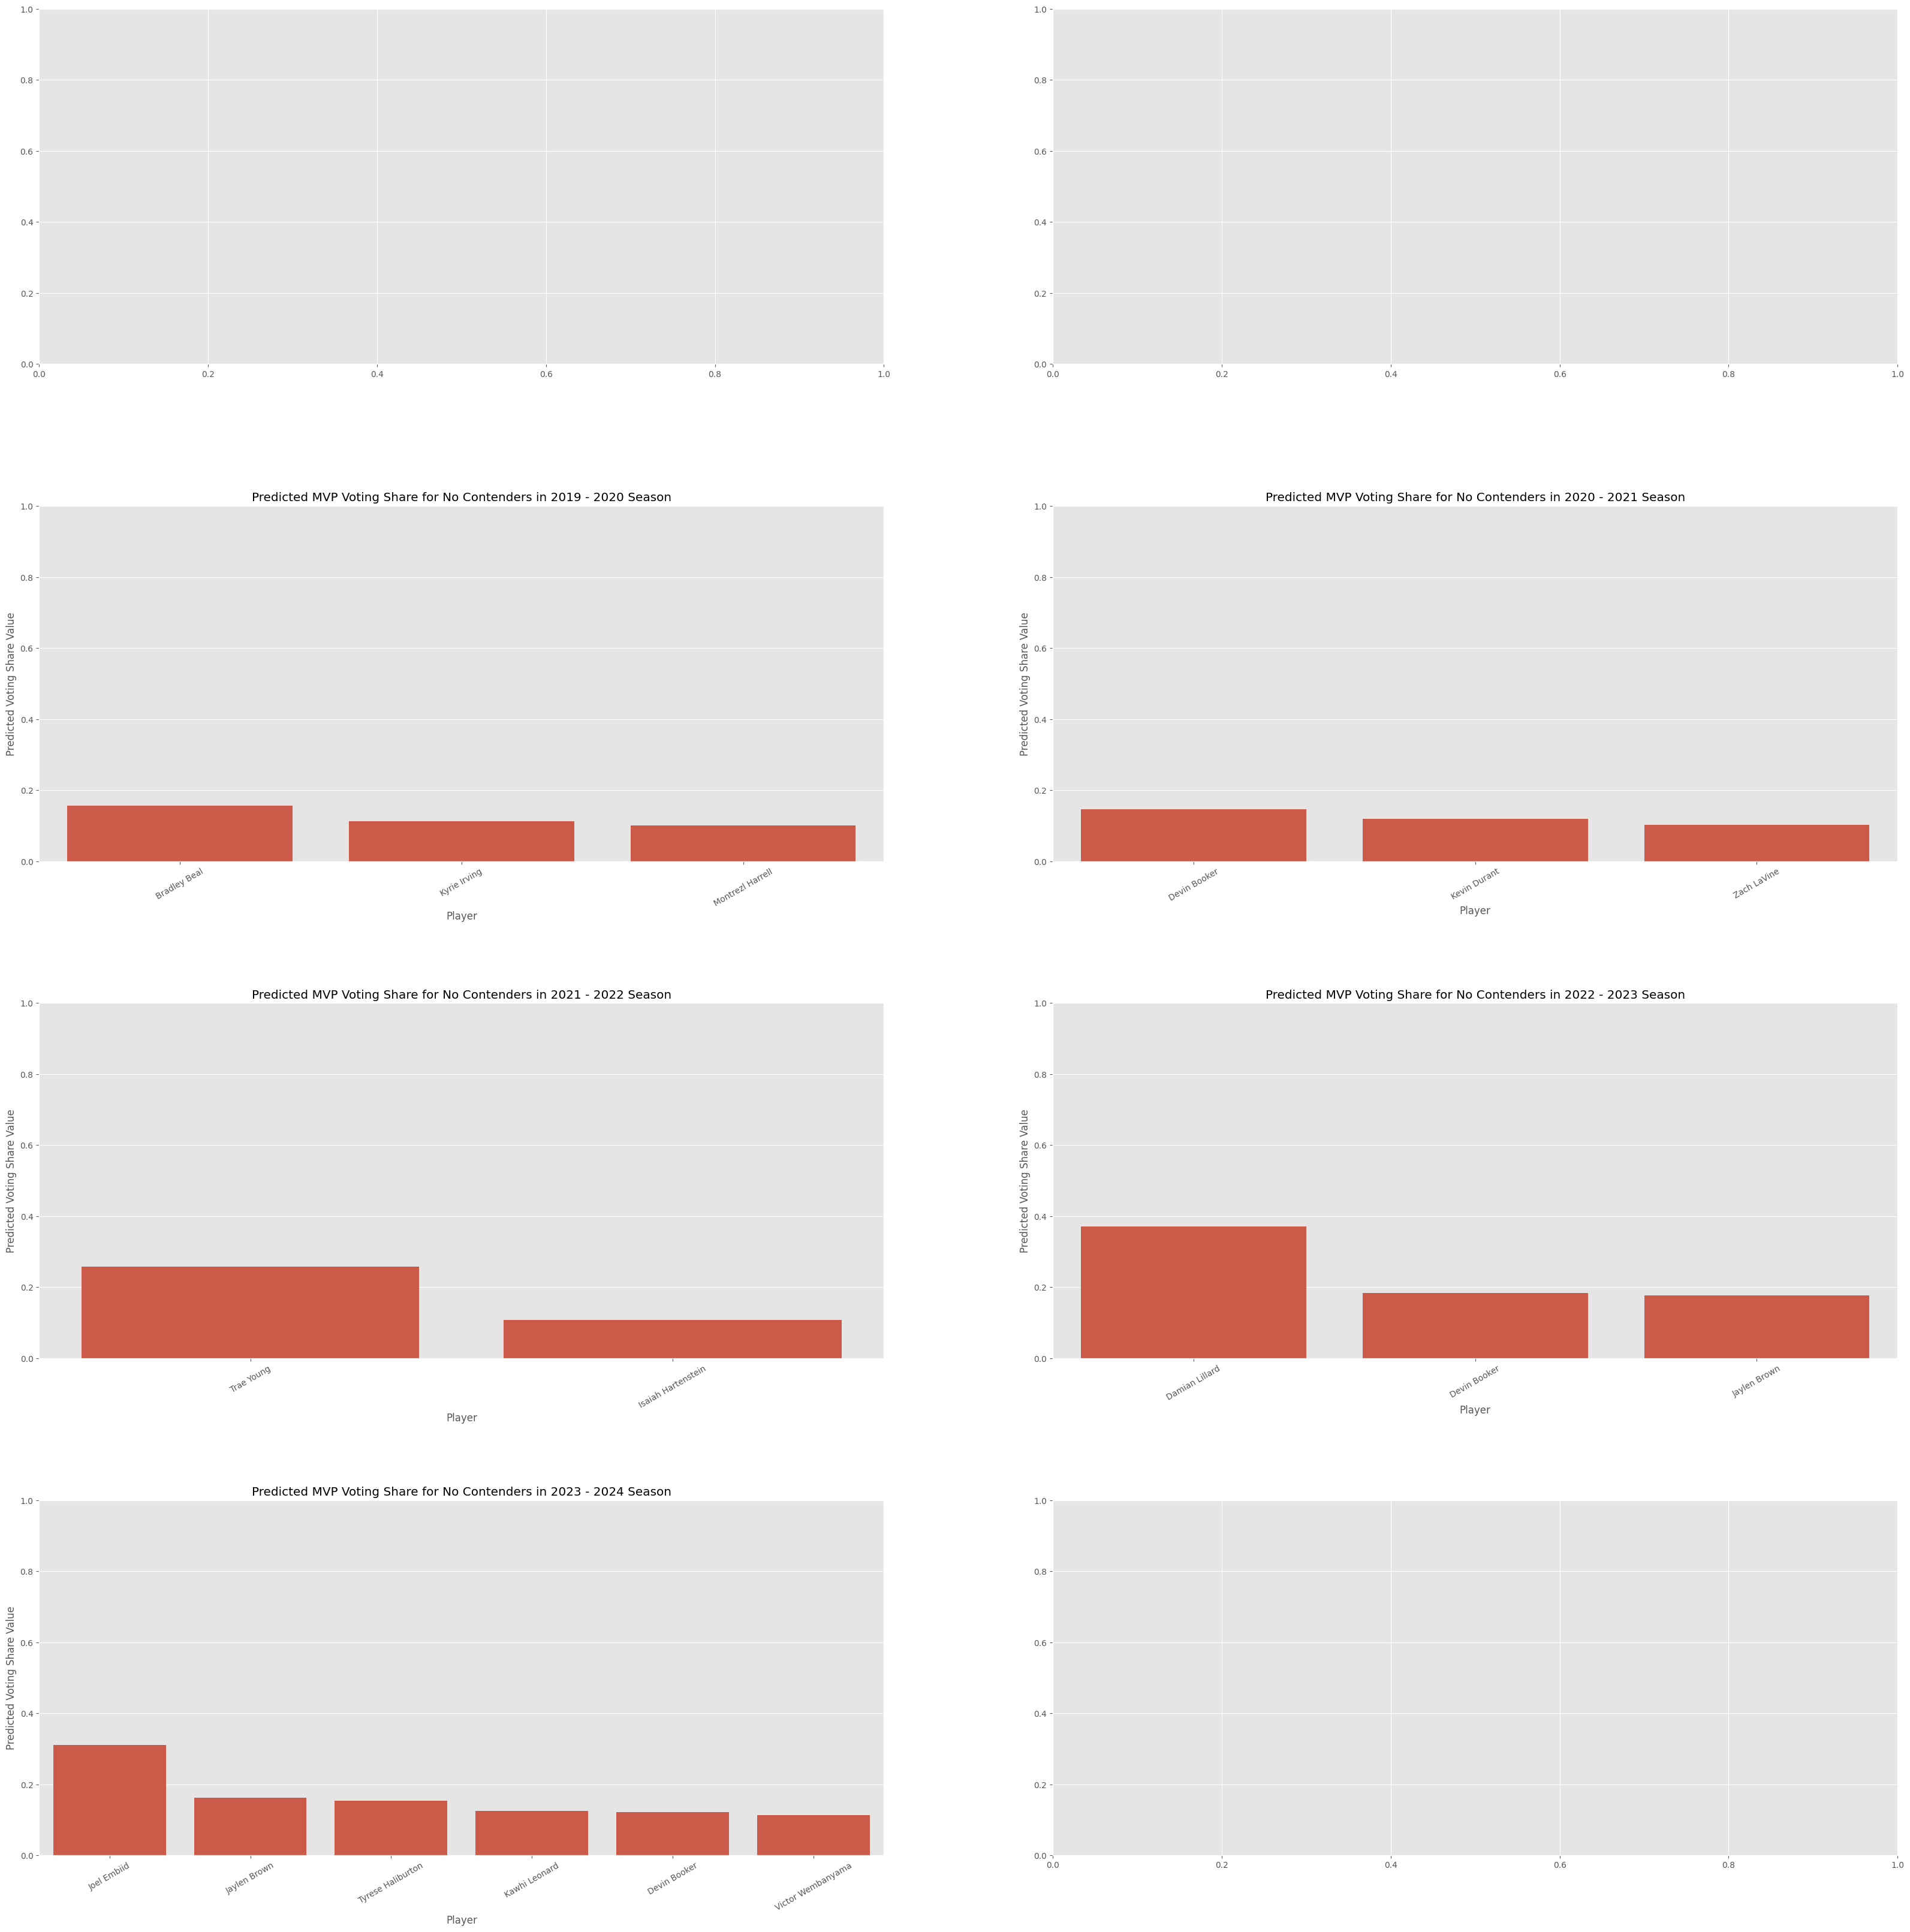

In [33]:
mod.display_val_results_graphs(real_targets['val'], predicted_targets['val'])